In [2]:
import warnings
warnings.filterwarnings("ignore")

# Spatial Data

In [1]:
import pandas
import osmnx
import geopandas
import rioxarray
import xarray
import datashader
import contextily as cx
from shapely.geometry import box
import matplotlib.pyplot as plt

In [ ]:
osmnx.config(
    overpass_settings='[out:json][timeout:90][date:"2021-10-07T00:00:00Z"]'
)

This chapter grounds the ideas discussed in the previous two chapters into a practical context. We consider how structures, and the models they represent, are implemented in Python, as well as how we can manipulate the data they contain. This will happen alongside the code used to manipulate the data in a single computational laboratory notebook. This, then, unites the two concepts. 

Further, we will spend most of the chapter discussing how Python represents data *once read* from a file or database, rather than focusing on specific *file* formats used to store data. This is because the libraries we use will read any format into one of a few canonical data structures that we discuss in Chapter 1.  We take this approach because these data structures are what we interact with during our data analysis: they our interface with the data. Indeed, part of the benefit of Python (and other computing languages) is *abstraction*. The complexities, particularities and quirks associated with each file format are removed as Python represents all data in a few standard ways, regardless of provenance. We take full advantage of this feature here. 

We divide the chapter in two main parts. The first part looks at each of the three main data structures reviewed in Chapter 1 (*Geographic Thinking*): geographic tables, surfaces and spatial graphs. Second, we explore combinations of different data structures that depart from the traditional data model/structure matchings discussed in Chapter 2. We cover how one data in one structure can be effectively transferred to another, but also discuss why that might (or might not) be a good idea in some cases. A final note before we delve into the content of this book is in order: this is not a comprehensive account of *everything* that is possible with each of the data structures we present. Rather, you can think of it as a taster that we will build on throughout the book to showcase much of what is possible with Python.

## Fundamentals

As outlined in Chapter 2, there are a few main data structures that are used in geographic data science: geographic tables (which are generally matched to an object data models), rasters or surfaces (which are generally matched to a field data model), and spatial networks (which are generally matched to a graph data model). We discuss these in turn throughout this section. 

### Geographic Tables

Geographic objects are usually matched to what we called the *geographic table*. Geographic tables can be thought of as a tab in a spreadsheet where one of the columns records geometric information. This data structure represents a single geographic object as a row of a table; each column in the table records information about the object, its attributes or features, as we will see below. Typically, there is a special column in this table that records the *geometry* of the object. Computer systems that use this data structure are intended to add geography into a *relational database*, such as PostgreSQL (through its PostGIS extension) or sqlite (through its spatialite extension). Beyond this, however, many data science languages (such as R, Julia, and Python), have packages that adopt this data structure as well (such as `sf`, `ArchGDAL`, and `geopandas`), and it is rapidly becoming the main data structure for object-based geographic data. 

Before proceeding, though, it helps to mention a quick clarification on terminology. Throughout this book, regardless of the data structure used, we will refer to a measurement about an observation as a *feature*. This is consistent with other work in data science and machine learning. Then, one set of measurements is a *sample*. For tables, this means a feature is a column and a sample is a row. Historically, though, geographic information scientists have used the word "feature" to mean an individual observation, since a "feature" in cartography is an entity on a map, and "attribute" to describe characteristics of that observation. Elsewhere, a *feature* may be called a *variable*, and a *sample* referred to as a record. So, consistent terminology is important: for this book, a *feature* is one measured trait pertaining to an observation (a column), and a *sample* is one set of measurements (a row). 

To understand the structure of geographic tables, it will help to read in the `countries_clean.gpkg` dataset included in this book that describes countries in the world. To read in this data, we can use the `read_file()` method in `geopandas`:^[We will generally use two curved brackets (such as `method_name()`) to denote a *function*, and will omit them (such as `package`) when referring to an object or package.]

In [2]:
gt_polygons = geopandas.read_file("../data/countries/countries_clean.gpkg")

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


And we can examine the top of the table with the `.head()` method:

In [3]:
gt_polygons.head()

,ADMIN,geometry
0,Indonesia,"MULTIPOLYGON (((13102705.696 463877.598, 13102..."
1,Malaysia,"MULTIPOLYGON (((13102705.696 463877.598, 13101..."
2,Chile,"MULTIPOLYGON (((-7737827.685 -1979875.500, -77..."
3,Bolivia,"POLYGON ((-7737827.685 -1979875.500, -7737828...."
4,Peru,"MULTIPOLYGON (((-7737827.685 -1979875.500, -77..."


Each row of this table is a single country. Each country only has two features: the administrative name of the country and the geometry of the country's boundary. The name of the country is encoded in the `ADMIN` column using the Python `str` type, which is used to store text-based data. The geometry of the country's boundary is stored in the `geometry` column, and is encoded using a special class in Python that is used to represent geometric objects. As with other table-based data structures in Python, every row and column have an index that identifies them uniquely and is rendered in bold on the left-hand side of the table. This geographic table is an instance of the `geopandas.GeoDataFrame` object, used throughout Python's ecosystem to represent geographic data.

Geographic tables store geographic information as an additional column. But, how is this information encoded? To see, we can check the type of the object in the first row:

In [4]:
type(gt_polygons.geometry[0])

shapely.geometry.multipolygon.MultiPolygon

In `geopandas` (as well as other packages representing geographic data), the `geometry` column has special traits which a "normal" column, such as `ADMIN`, does not. For example, when we plot the dataframe, the `geometry` column is used as the main shape to use in the plot:

<AxesSubplot:>

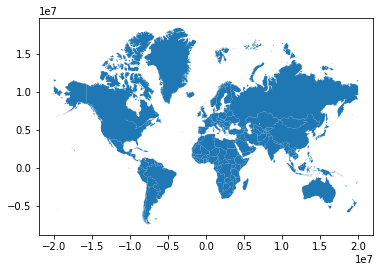

In [5]:
gt_polygons.plot()

Changing geometries must be done carefully: since the `geometry` column is special, there are special functions to adjust the geometry. For example, if we wanted to represent each country using its *centroid*, a point in the middle of the shape, then we must take care to make sure that a new geometry column was set properly using the `set_geometry()` method. This can be useful when you want to work with two different geometric representations of the same underlying sample. 

Let us make a map of both the boundary and the centroid of a country. First, to compute the centroid, we can use the `gt_polygons.geometry.centroid` property. This gives us the point that minimizes the average distance from all other points on the boundary of the shape. Storing that back to a column, called `centroid`:

In [6]:
gt_polygons['centroid'] = gt_polygons.geometry.centroid

We now have an additional feature:

In [7]:
gt_polygons.head()

,ADMIN,geometry,centroid
0,Indonesia,"MULTIPOLYGON (((13102705.696 463877.598, 13102...",POINT (13055431.810 -248921.141)
1,Malaysia,"MULTIPOLYGON (((13102705.696 463877.598, 13101...",POINT (12211696.493 422897.505)
2,Chile,"MULTIPOLYGON (((-7737827.685 -1979875.500, -77...",POINT (-7959811.948 -4915458.802)
3,Bolivia,"POLYGON ((-7737827.685 -1979875.500, -7737828....",POINT (-7200010.945 -1894653.148)
4,Peru,"MULTIPOLYGON (((-7737827.685 -1979875.500, -77...",POINT (-8277554.831 -1032942.536)


Despite the fact that `centroid` is a geometry, it is not currently set as the geometry for our table. We can switch to the `centroid` column using the `set_geometry()` method. Finally, we can plot the centroid and the boundary of each country by switching the geometry column with `set_geometry`:

<AxesSubplot:>

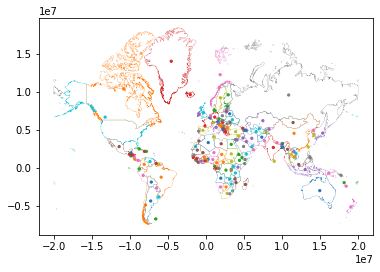

In [8]:
# Plot centroids
ax = gt_polygons.set_geometry('centroid')\
                .plot('ADMIN', 
                      markersize=5
                     )
# Plot polygons without color filling
gt_polygons.plot('ADMIN', 
                 ax=ax, 
                 facecolor='none', 
                 edgecolor='k', 
                 linewidth=.2
                )

Note how we can create a map by calling `.plot()` on a `GeoDataFrame`. We can thematically color each feature based on a column by passing the name of that column to the plot method (as we do on with `ADMIN` in this case).

Thus, as should now be clear, nearly any kind of geographic object can be represented in one (or more) geometry column(s). Thinking about the number of different kinds of shapes or geometries one could draw quickly boggles the mind. Fortunately the Open Geospatial Consortium (OGC) has defined a set of "abstract" types that can be used to define any kind of geometry. This specification, codified in ISO 19125-1---the "simple features" specification---defines the formal relationships between these types: a `Point` is a zero-dimensional location with an x and y coordinate; a `LineString` is a path composed of a set of more than one `Point`, and a `Polygon` is a surface that has at least one LineString that starts and stops with the same coordinate. All of these types *also* have `Multi` variants that indicate a collection of multiple geometries of the same type. So, for instance, Bolivia is represented as a single polygon:

In [9]:
gt_polygons.query('ADMIN == "Bolivia"')

,ADMIN,geometry,centroid
3,Bolivia,"POLYGON ((-7737827.685 -1979875.500, -7737828....",POINT (-7200010.945 -1894653.148)


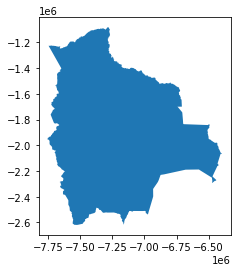

In [10]:
gt_polygons.query('ADMIN == "Bolivia"').plot();

while Indonesia is a `MultiPolygon` containing many `Polygons` for each individual island in the country:

In [11]:
gt_polygons.query('ADMIN == "Indonesia"')

,ADMIN,geometry,centroid
0,Indonesia,"MULTIPOLYGON (((13102705.696 463877.598, 13102...",POINT (13055431.810 -248921.141)


<AxesSubplot:>

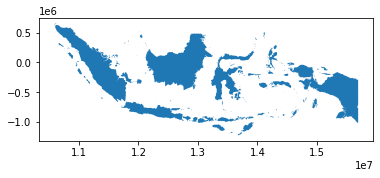

In [12]:
gt_polygons.query('ADMIN == "Indonesia"').plot()

In many cases, geographic tables will have geometries of a single type; records will *all* be `Point` or `LineString`, for instance. However, there is no formal requirement that a *geographic table* has geometries that all have the same type. 

Throughout this book, we will use geographic tables extensively, storing polygons, but also points and lines. We will explore lines a bit more in the second part of this chapter but, for now, let us stop on points for a second. As mentioned above, these are the simplest type of feature in that they do not have any dimension, only a pair of coordinates attached to them. This means that points can sometimes be stored in a non-geographic table, simply using one column for each coordinate. We find an example of this on the Tokyo dataset we will use more later. The data is stored as a comma-separated value table, or `.csv`:

In [13]:
gt_points = pandas.read_csv("../data/tokyo/tokyo_clean.csv")

Since we have read it with `pandas`, the table is loaded as a `DataFrame`, with no explicit spatial dimension:

In [14]:
type(gt_points)

pandas.core.frame.DataFrame

If we inspect the table, we find there is not a `geometry` column:

In [15]:
gt_points.head()

,user_id,longitude,latitude,date_taken,photo/video_page_url,x,y
0,10727420@N00,139.700499,35.674000,2010-04-09 17:26:25.0,http://www.flickr.com/photos/10727420@N00/4545...,1.555139e+07,4.255856e+06
1,8819274@N04,139.766521,35.709095,2007-02-10 16:08:40.0,http://www.flickr.com/photos/8819274@N04/26503...,1.555874e+07,4.260667e+06
2,62068690@N00,139.765632,35.694482,2008-12-21 15:45:31.0,http://www.flickr.com/photos/62068690@N00/3125...,1.555864e+07,4.258664e+06
3,49503094041@N01,139.784391,35.548589,2011-11-11 05:48:54.0,http://www.flickr.com/photos/49503094041@N01/6...,1.556073e+07,4.238684e+06
4,40443199@N00,139.768753,35.671521,2006-04-06 16:42:49.0,http://www.flickr.com/photos/40443199@N00/2482...,1.555899e+07,4.255517e+06


Many point datasets are provided in this format. To make the most of them, it is convenient to convert them into `GeoDataFrame` tables. There are two steps involved in this process:

1. Turn coordinates into geometries:

In [16]:
pt_geoms = geopandas.points_from_xy(x=gt_points["longitude"],
                                    y=gt_points["latitude"],
                                    crs="EPSG:4326"
                                   )

2. Create a `GeoDataFrame` object:

In [17]:
gt_points = geopandas.GeoDataFrame(gt_points,
                                   geometry=pt_geoms
                                  )

And now `gt_points` looks and feels exactly like the one of countries we have seen before, with the difference the `geometry` column stores `POINT` geometries:

In [18]:
gt_points.head()

,user_id,longitude,latitude,date_taken,photo/video_page_url,x,y,geometry
0,10727420@N00,139.700499,35.674000,2010-04-09 17:26:25.0,http://www.flickr.com/photos/10727420@N00/4545...,1.555139e+07,4.255856e+06,POINT (139.70050 35.67400)
1,8819274@N04,139.766521,35.709095,2007-02-10 16:08:40.0,http://www.flickr.com/photos/8819274@N04/26503...,1.555874e+07,4.260667e+06,POINT (139.76652 35.70909)
2,62068690@N00,139.765632,35.694482,2008-12-21 15:45:31.0,http://www.flickr.com/photos/62068690@N00/3125...,1.555864e+07,4.258664e+06,POINT (139.76563 35.69448)
3,49503094041@N01,139.784391,35.548589,2011-11-11 05:48:54.0,http://www.flickr.com/photos/49503094041@N01/6...,1.556073e+07,4.238684e+06,POINT (139.78439 35.54859)
4,40443199@N00,139.768753,35.671521,2006-04-06 16:42:49.0,http://www.flickr.com/photos/40443199@N00/2482...,1.555899e+07,4.255517e+06,POINT (139.76875 35.67152)


### Surfaces

Surfaces are used to record data from a field data model. In theory, a field is a continuous surface and thus has an infinite number of locations at which it could be measured. In reality however, fields are measured at a finite sample of locations that, to provide a sense of continuity and better conform with the field model, are uniformly structured across space. Surfaces thus, are represented as grids where each cell contains a sample. A grid can also be thought of as a table with rows and columns but, as we discussed in the previous chapter, both of them are directly tied to geographic location. This is in sharp contrast with geographic tables, where geography is confined to a single column.

To explore how Python represents surfaces, we will use an extract for the Brazilian city of Sao Paulo of a [global population dataset](../data/ghsl/build_ghsl_extract). This dataset records population counts in cells of the same dimensions uniformly covering the surface of the Earth. Our extract is available as a GeoTIF file, a variation of the TIF image format that includes geographic information. We can use the `open_rasterio()` method from the `xarray` package to read in the GeoTIF:

In [19]:
pop = xarray.open_rasterio("../data/ghsl/ghsl_sao_paulo.tif")

This reads the data into a `DataArray` object:

In [20]:
type(pop)

xarray.core.dataarray.DataArray

`xarray` is a package to work with multi-dimensional labeled arrays. Let's unpack this: we can use arrays of not only two dimensions as in a table with rows and columns, but with an arbitrary number of them; each of these dimensions are "tracked" by an index that makes it easy and efficient to manipulate. In `xarray`, these indices are called coordinates, and they can be retrieved from our `DataArray` through the `coords` attribute:

In [21]:
pop.coords

Coordinates:
  * band     (band) int64 1
  * y        (y) float64 -2.822e+06 -2.822e+06 ... -2.926e+06 -2.926e+06
  * x        (x) float64 -4.482e+06 -4.482e+06 ... -4.365e+06 -4.365e+06

Interestingly, our surface has *three* dimensions: `x`, `y`, and `band`. The former to track the latitude and longitude that each cell in our population grid covers. The third one has a single value (1) and, in this context, it is not very useful. But it is easy to imagine contexts where a third dimension would be useful. For example, an optical color image may have three bands: red, blue, and green. More powerful sensors may pick up additional bands, such as near infrared (NIR) or even radio bands. Or, a surface measured over time, like the geocubes that we discussed in Chapter 2, will have bands for each point in time at which the field is measured. A geographic surface will thus have two dimensions recording the location of cells (`x` and `y`), and at least one `band` that records other dimensions pertaining to our data.

An `xarray.DataArray` object contains additional information about the values stored under the `attrs` attribute:

In [22]:
pop.attrs

{'transform': (250.0, 0.0, -4482000.0, 0.0, -250.0, -2822000.0),
 'crs': '+proj=moll +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs=True',
 'res': (250.0, 250.0),
 'is_tiled': 0,
 'nodatavals': (-200.0,),
 'scales': (1.0,),
 'offsets': (0.0,),
 'AREA_OR_POINT': 'Area',
 'grid_mapping': 'spatial_ref'}

In this case, we can see this includes information required to convert pixels in the array into locations on the Earth surface (e.g. `transform`, and `crs`), the resolution (250 meters by 250 meters), and other metadata that allows us to better understand where the data comes from and how it is stored.

Thus, our `DataArray` has three dimensions:

In [23]:
pop.shape

(1, 416, 468)

A common operation will be to reduce this to only the two geographic ones. We can do this with the `sel` operator, which allows us to select data by the value of their coordinates:

In [24]:
pop.sel(band=1)

<xarray.DataArray (y: 416, x: 468)>
[194688 values with dtype=float32]
Coordinates:
    band     int64 1
  * y        (y) float64 -2.822e+06 -2.822e+06 ... -2.926e+06 -2.926e+06
  * x        (x) float64 -4.482e+06 -4.482e+06 ... -4.365e+06 -4.365e+06
Attributes:
    transform:      (250.0, 0.0, -4482000.0, 0.0, -250.0, -2822000.0)
    crs:            +proj=moll +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +...
    res:            (250.0, 250.0)
    is_tiled:       0
    nodatavals:     (-200.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    grid_mapping:   spatial_ref

The resulting object is thus a two-dimensional array. Similar to geographic tables, we can quickly plot the values in our dataset:

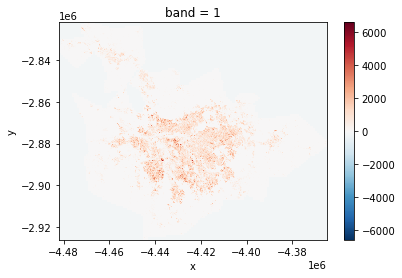

In [25]:
pop.sel(band=1).plot()

This gives us a first overview of the distribution of population in the Sao Paulo region. However, if we inspect further, we can see that the map includes negative counts! How could this be? As it turns out, missing data are traditionally stored in surfaces not as a class of its own (e.g. `NaN`) but with an impossible value. If we return to the `attrs` printout above, we can see how the `nodatavals` attribute specifies missing data recorded with -200. With that in mind, we can use the `where()` method to select only values that are *not* -200:

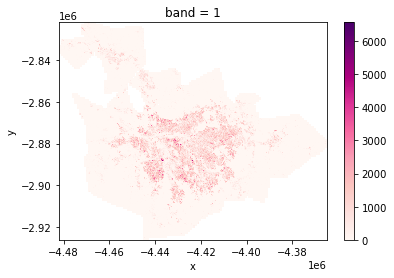

In [26]:
pop.where(pop!=-200)\
   .sel(band=1)\
   .plot(cmap="RdPu")

The colorbar now looks more sensible, and indicates *real* counts, rather than including the missing data placeholder values.

### Spatial graphs

Spatial graphs store connections between objects through space. These connections may derive from geographical topology (e.g. contiguity), distance, or more sophisticated dimensions such as interaction flows (e.g. commuting, trade, communication). Compared to geographic tables and surfaces, spatial graphs are rather different. First, in most cases they do not record measurements about a given phenomena, but instead focus on *connections*, on storing relationships between objects as they are facilitated (or impeded in their absence) by space. Second, because of this relational nature, the data are organized in a more unstructured fashion: while one sample may be connected to only one other sample, another one can display several links. This in stark contrast to geographic tables and surfaces, both of which have a clearly defined structure, shape and dimensionality in which data are organized. These particularities translate into a different set of Python data structures. Unlike the previous ones we have seen, there are different data structures to represent spatial graphs, each optimized for different contexts. One of such cases is the integration of spatial connections in statistical methods such as exploratory data analysis or regression. For this, the most common data structure are spatial weights matrices, to which we devote the next chapter. 

In this chapter, we briefly review a different way of representing spatial graphs that is much closer to the mathematical concept of a graph. A graph is composed of *nodes* that are linked together by *edges*. In a spatial network, *nodes* may represent geographical places, and thus have a specific location; likewise, *edges* may represent geographical paths between these places. Networks require both *nodes* and *edges* to analyze their structure. 

For illustration, we will rely on the `osmnx` library, which can query data from OpenStreetMap. For example, we extract the street-based graph of Yoyogi Park, near our earlier data from Tokyo:

In [32]:
%%time
graph = osmnx.graph_from_place("Yoyogi Park, Shibuya, Tokyo, Japan")

CPU times: user 847 ms, sys: 24.7 ms, total: 871 ms
Wall time: 869 ms


In [29]:
osmnx.save_graphml(graph, "../data/cache/yoyogi_park_graph.graphml")

The code snippet above sends the query to the OpenStreetMap server to fetch the data. Note that the cell above _requires_ internet connectivity to work. If you are working on the book _without_ connectivity, a cached version of the graph is available on the data folder and can be read as:

In [30]:
graph = osmnx.load_graphml("../data/cache/yoyogi_park_graph.graphml")

Once the data is returned to `osmnx`, it gets processed into the `graph` Python representation:

In [33]:
type(graph)

networkx.classes.multidigraph.MultiDiGraph

We can have a quick inspection of the structure of the graph with the `plot_graph` method:

In [ ]:
osmnx.plot_graph(graph)

The resultant `graph` object is actually a `MultiDiGraph` from `networkx`, a graph library written in Python. The graph here is stored as a collection of 106 nodes (street intersections):

In [ ]:
len(graph.nodes)

and 287 edges (streets) that connect them:

In [ ]:
len(graph.edges)

Each of these elements can be queried to obtain more information such as the location and ID of a node:

In [ ]:
graph.nodes[1520546819]

The characteristics of an edge:

In [ ]:
graph.edges[(1520546819, 3010293622, 0)]

Or how the different components of the graph relate to each other. For example, what other nodes are directly connected to node `1520546819`?

In [ ]:
list(graph.adj[1520546819].keys())

Thus, networks are easy to represent in Python, and are one of the three main data structures in geographic data science. 

## Hybrids

We have just seen how geographic tables, surfaces, and networks map onto `GeoDataFrame`, `DataArray` and `Graph` objects in Python, respectively. These represent the conventional pairings that align data models to data structures with Python representations. However, Thus, while the conventional pairings are well-used, there are others in active use and many more to yet be developed. Interestingly, many new pairings are driven by new developments in technology, enabling approaches that were not possible in the past or creating situations (e.g. large datasets) that make the conventional approach limiting. Therefore, in this second section of the chapter, we step a bit "out of the box" to explore cases in which it may make sense to represent a dataset with a data structure that might not be the most obvious initial choice. 

(ch03-surfaces_as_tables)=
### Surfaces as tables

The first case we explore is treating surfaces as (geo-)tables. In this context, we shift from an approach where each dimension has a clear mapping to a spatial or temporal aspect of the dataset, to one where each sample, cell of the surface/cube is represented as a row in a table. This approach runs contrary to the general consensus that fields are best represented as surfaces or rasters because that allows us to index space and time "by default" based on the location of values within the data structure. Shifting to a tabular structure implies either losing that space-time reference, or having to build it manually with auxiliary objects (e.g. a spatial graph). In almost any case, operating on this format is less efficient than it *could* be if we had bespoke algorithms built around surface structures. Finally, from a more conceptual point of view, treating pixels as independent realizations of a process that we *know* is continuous is can be computationally inefficient and statistically flawed. 

This perspective however also involves important benefits. First, sometimes we *don't* need location for our particular application. Maybe we are interested in calculating overall descriptive statistics; or maybe we need to run an analysis that is entirely atomic in the sense that it operates on each sample in isolation from all the other ones.  Second, by "going tabular" we recast our specialized, spatial data into the most common data structure available, for which a large amount of commodity technology is built. This means many new tools can be used for analysis. So called "big data" technologies, such as distributed systems, are much more common, robust, and tested for tabular data than for spatial surfaces. *If* we can translate our spatial challenge into a tabular challenge, we can immediately plug into technology that is more optimized and, in some cases, reliable. Further, some analytic toolboxes common in (geographic) data science are entirely built around tabular structures. Machine learning packages such as `scikit-learn`, or some spatial analytics (such as most methods in `PySAL`) are designed around this data structure. Converting our surfaces into tables thus allows us to plug into a much wider suite of (potentially) efficient tools and techniques.

We will see two ways of going from surfaces to tables: one converts every pixel into a table row, and another that aggregates pixels into predetermined polygons.

#### One pixel at a time

Technically, going from surface to table involves traversing from `xarray` to `pandas` objects. This is actually a well established bridge. To illustrate it with a example, let's revisit the [population counts in [Sao Paulo](../data/ghsl/build_ghsl_extract) used earlier. We can read the surface into a `DataArray` object with the `open_rasterio()` method:

In [ ]:
surface = xarray.open_rasterio("../data/ghsl/ghsl_sao_paulo.tif")

Transferring to a table is as simple as calling the `DataArray`'s `to_series()` method:

In [ ]:
t_surface = surface.to_series()

The resulting object is a `pandas.Series` object indexed on each of the dimensions of the original `DataArray`:

In [ ]:
t_surface.head()

At this point, everything we know about `pandas` and tabular data applies! For example, it might be more convenient to express it as a `DataFrame`:

In [ ]:
t_surface = t_surface.reset_index().rename(columns={0: "Value"})

With the power of a tabular library, some queries and filter operations become much easier. For example, finding cells with more than 1,000 people can be done with the usual `query()` method^[Although, if all you want to do is this type of query, `xarray` is well equipped for this kind of task too.]:

In [ ]:
t_surface.query("Value > 1000").info()

The table we have built has no geometries associated with it, only rows representing pixels. It takes a bit more effort, but it is possible to convert it, or a subset of it, into a fully-fledged geographic table, where each pixel includes the grid geometry it represents. For this task, we develop a simple function that takes a row from our table and the resolution of the surface, and returns its geometry:

In [ ]:
def row2cell(row, res_xy):
    res_x, res_y = res_xy
    minX = row["x"]
    maxX = row["x"] + res_x
    minY = row["y"] + res_y
    maxY = row["y"]
    poly = box(minX, minY, maxX, maxY)
    return poly

For example:

In [ ]:
row2cell(t_surface.loc[0, :], surface.attrs["res"])

One of the benefits of this approach is we do not require entirely filled surfaces and can only record pixels where we have data. For the example above or cells with more than 1,000 people, we could create the associated geo-table as follows:

In [ ]:
max_polys = t_surface.query("Value > 1000")\
                     .apply(row2cell, 
                            res_xy=surface.attrs["res"], 
                            axis=1
                           )
max_polys = geopandas.GeoSeries(max_polys, crs=surface.attrs["crs"])

And generate a map with the same tooling that we use for any standard geo-table:

In [ ]:
ax = max_polys.plot(edgecolor="red", 
                    figsize=(9, 9)
                   )
cx.add_basemap(ax, 
               crs=surface.attrs["crs"], 
               source=cx.providers.CartoDB.Voyager
              )

Finally, once we have operated on the data as a table, we may want to return to a surface-like data structure. This involves taking the same journey in the opposite direction as how we started. The sister method of `to_series` in `xarray` is `from_series`:

In [ ]:
new_da = xarray.DataArray.from_series(
    t_surface.set_index(["band", "y", "x"])["Value"]
)
new_da

#### Pixels to polygons

A second use case involves moving surfaces directly into geographic tables by aggregating pixels into pre-specified geometries. For this illustration, we will use the [DEM](../data/nasadem/build_nasadem_sd) surface containing elevation for the San Diego (US) region, and the set of [Census tracts](../data/sandiego/sandiego_tracts_cleaning). For an example, we will investigate the average altitude of each neighborhood.

Let's start by reading the data. First, the elevation model:

In [ ]:
dem = xarray.open_rasterio("../data/nasadem/nasadem_sd.tif").sel(band=1)
dem.where(dem > 0).plot.imshow()

And the neighborhood areas (tracts) from the Census:

In [ ]:
sd_tracts = geopandas.read_file("../data/sandiego/sandiego_tracts.gpkg")
sd_tracts.plot()

There are several approaches to compute the average altitude of each neighborhood. We will use `rioxarray`to clip parts of the surface *within* a given set of geometries. Let's start with a single polygon. For the illustration, we will use the largest one, located on the eastern side of San Diego. We can find the ID of the polygon with:

In [ ]:
largest_tract_id = sd_tracts.query(f"area_sqm == {sd_tracts['area_sqm'].max()}").index[0]
largest_tract_id

And then pull out the polygon itself for the illustration:

In [ ]:
largest_tract = sd_tracts.loc[largest_tract_id, "geometry"]

Clipping the section of the surface that is within the polygon in the DEM can be achieved with the `rioxarray` extension to clip surfaces based on geometries:

In [ ]:
dem_clip = dem.rio.clip([largest_tract.__geo_interface__], 
                        crs=sd_tracts.crs
                       )
dem_clip.where(dem_clip > 0).plot()

Once we have elevation measurements for all the pixels within the tract, the average one can be calculated with `mean()`:

In [ ]:
dem_clip.where(dem_clip > 0).mean()

Now, to scale this to the entire geo-table, there are several approaches, each with benefits and disadvantages. We opt for applying the method above to each row of the table. We define an auxiliary function that takes a row containing one of our tracts and returns its elevation:

In [ ]:
def get_mean_elevation(row):
    geom = row["geometry"].__geo_interface__
    section = dem.rio.clip([geom], crs=sd_tracts.crs)
    ele = float(section.where(section > 0).mean())
    return ele

Applied to the same tract, it returns the same average elevation:

In [ ]:
get_mean_elevation(sd_tracts.loc[largest_tract_id, :])

This method can then be run on each polygon in our series using the `apply`:

In [ ]:
elevations = sd_tracts.head().apply(get_mean_elevation, axis=1)
elevations

This simple approach illustrates the main idea well: find the cells that pertain to a given geometry and summarize their values in some manner. This can be done with any kind of geometry. Further, this simple method plays well with `xarray` surface structures and is scalable in that it is not too involved to run in parallel and distributed with Dask, and can be extended using arbitrary Python functions. 

However, this approach can be quite slow in big data. A more efficient alternative for our example is using the `rasterstats` library. This is a purpose-built library to construct so-called "zonal statistics" from surfaces. Here, the "zones" are the polygons and the "surface" is our `DataArray`. Generally, this library will be faster than the simpler approach used above, but may be more difficult to extend or adapt:

In [ ]:
%%time
from rasterstats import zonal_stats

elevations2 = zonal_stats(sd_tracts.to_crs(dem.rio.crs),
                          "../data/nasadem/nasadem_sd.tif"
                         )
elevations2 = pandas.DataFrame(elevations2)

In [ ]:
elevations2.head()

To visualize these results, we can make an elevation map:

In [ ]:
f, axs = plt.subplots(1, 3, figsize=(15, 5))
dem.where(dem > 0)\
   .rio.reproject(sd_tracts.crs)\
   .plot.imshow(ax=axs[0], add_colorbar=False)
sd_tracts.plot(ax=axs[1])
sd_tracts.assign(elevation=elevations2["mean"]).plot("elevation", ax=axs[2])

### Tables as surfaces

The case for converting tables into surfaces is perhaps less controversial. This is an approach we can take in cases where we are interested in the *overall* distribution of objects (usually points) and we have so many that it is not only technically more efficient to represent them as a surface, but conceptually it is also easier to think about the points as uneven measurements from a continuous field. To illustrate this approach, we will use the dataset of [Tokyo photographs](../data/tokyo/tokyo_cleaning) we loaded above into `gt_points`.

From a purely technical perspective, for datasets with too many points, representing every point in the data on a screen can be seriously overcrowded:

In [ ]:
gt_points.plot()

In the image above, it is hard to tell anything about the density of points in the center of the image due to *overplotting*: while points *theoretically* have no width, they must in order for us to see them! Therefore, point *markers* often plot on top of one another, obscuring the true pattern and density in dense areas. Converting the dataset from a geo-table into a surface involves laying out a grid and counting how many points fall within each cell. In one sense, this is the reverse operation to what we saw when computing zonal statistics in the previous section: instead of aggregating cells into objects, we aggregate objects into cells. Both operations, however, involve aggregation that reduces the amount of information present in order to make the (new) data more manageable. 

In Python, we can rely on the `datashader` library, which does all the computation in a very efficient way. This process involves two main steps. First, we set up the grid (or canvas, `cvs`) into which we want to aggregate points:

In [ ]:
cvs = datashader.Canvas(plot_width=60,
                        plot_height=60
                       )

Then we "transfer" the points into the grid:

In [ ]:
grid = cvs.points(gt_points, 
                  x="longitude", 
                  y="latitude"
                 )

The resulting `grid` is a standard `DataArray` object that we can then manipulate as we have seen before. When plotted below, the amount of detail that the re-sampled data allows for is much greater than when the points were visualized alone:

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(14, 6))
gt_points.plot(ax=axs[0])
grid.plot(ax=axs[1]);

### Networks as graphs *and* tables

In the previous chapter, we saw networks as data structures that store *connections* between objects. We also discussed how this broad definition includes many interpretations that focus on different aspects of the networks. While spatial analytics may use graphs to record the topology of a table of objects such as polygons; transport applications may treat the network representation of the street layout as a set of objects itself, in this case lines. In this final section we show how one can flip back and forth between one representation and another, to take advantage of different aspects.

We start with the `graph` object from the [previous section](#Spatial-graphs). Remember this captures the street layout around Yoyogi park in Tokyo. We have seen how, stored under this data structure, it is easy to query which node is connected to which, and which ones are at the end of a given edge. 

However, in some cases, we may want to convert the graph into a structure that allows us to operate on each component of the network independently. For example, we may want to map streets, calculate segment lengths, or draw buffers around each intersection. These are all operations that do not require topological information, that are standard for geo-tables and that are irrelevant to the graph structure. In this context, it makes sense to convert our `graph` to two geo-tables, one for intersections (the graph nodes) and one for street segments (the graph edges). In `osmnx`, we can do that with the built-in converter:

In [ ]:
gt_intersections, gt_lines = osmnx.graph_to_gdfs(graph)

Now each of the resulting geo-tables behaves as a collection of geographic objects, because it is:

In [ ]:
gt_intersections.head()

In [ ]:
gt_lines.info()

If we were in the opposite situation, where we had a set of street segments and their intersections in geo-table form, we can generate the graph representation with the `graph_from_gdfs` sister method:

In [ ]:
new_graph = osmnx.graph_from_gdfs(gt_intersections, gt_lines)

The resulting object will behave in the same was as our original `graph`.

## Conclusion

In conclusion, this chapter provides an overview of the mappings between data models, presented in Chapter 2, and data structures that are common in Python. Beyond the data structures discussed here, the Python ecosystem is vast, deep, and ever-changing. Part of this is the ease with which you (yes, you!) can create your own representations to express different aspects of a problem at hand. However, by focusing on our shared representations and the interfaces between these representations, you can generally conduct any analysis you need. By creating unique, bespoke representations, your analysis might be more efficient, but you can also inadvertently isolate it from other developers and render useful tools inoperable. Therefore, a solid understanding of the basic data structures (the `GeoDataFrame`, `DataArray`, and `Graph`) will be sufficient to support nearly any analysis you need to conduct. 

## Questions

1. One way to convert from `Multi-`type geometries into many individual geometries is using the `explode()` method of a GeoDataFrame. Using the `explode()` method, can you find out how many islands are in Indonesia?

2. Using `osmnx`, are you able to extract the street graph for your hometown?

3. As you have seen with the `osmnx.graph_to_gdfs()` method, it is possible to convert a graph into the constituent nodes and edges. Graphs have many other kinds of non-geographical representations. Many of these are provided in `networkx` methods that start with `to_`. How many representations of graphs are currently supported?

4. Using `networkx.to_edgelist()`, what "extra" information does `osmnx` include when building the dataframe for edges?

5. Instead of computing the average elevation for each neighborhood in San Diego, can you answer the following queries?
  - What neighborhood (or neighborhoods) have the *the highest average elevation*?
  - What neighborhood (or neighborhoods) have *the highest point single point*?
  - Can you find the neighborhood (or neighborhoods) with *the largest elevation change*?